In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, classification_report, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

#dataset
data = pd.read_csv("cleaned_data_15_4_2024.csv")

#features and targets
feature_columns = ['age', 'Violence and Abuse', 'Accidents and Medical', 'Theft and Fraud',
                   'Loss and Death', 'gender_Female', 'gender_Male', 'gender_Other']
targets = ['Personal Support', 'Professional and Specialized Support', 'Community and Workplace Support', 'Legal and Official Support', 'No Help Sought']

#Split data into training, validation, and test sets based on the year
train_data = data[data['year_of_survey'] <= 2021]
validation_data = data[data['year_of_survey'] == 2022]
test_data = data[data['year_of_survey'] == 2023]


X_train, y_train = train_data[feature_columns], train_data[targets]
X_val, y_val = validation_data[feature_columns], validation_data[targets]
X_test, y_test = test_data[feature_columns], test_data[targets]

#Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#Hyperparameters to tune
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear']
}

#Define scoring
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(recall_score, average='macro')
}

#Empty list to hold all individual classifiers
classifiers = []

#Apply SMOTEENN and GridSearchCV for each label individually
for i, target in enumerate(targets):
    smote_enn = SMOTEENN(smote=SMOTE(random_state=42), enn=EditedNearestNeighbours(sampling_strategy='all'), random_state=42)
    X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train[target])
    
    #Define the model pipeline
    pipeline = Pipeline([
        ('logisticregression', LogisticRegression(random_state=42, max_iter=1000))
    ])
    
    #Grid search to find the best hyperparameters
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, refit='AUC')
    grid_search.fit(X_resampled, y_resampled)
    
    #Store the best model
    best_model = grid_search.best_estimator_
    classifiers.append(best_model)

#Evaluate every model on train, validation, test sets 
y_train_pred = np.column_stack([model.predict(X_train_scaled) for model in classifiers])
y_val_pred = np.column_stack([model.predict(X_val_scaled) for model in classifiers])
y_test_pred = np.column_stack([model.predict(X_test_scaled) for model in classifiers])

precision_train = precision_score(y_train, y_train_pred, average='macro')
recall_train = recall_score(y_train, y_train_pred, average='macro')
f1_train = f1_score(y_train, y_train_pred, average='macro')
roc_auc_train = np.mean([roc_auc_score(y_train.iloc[:, i], y_train_pred[:, i]) for i in range(y_train.shape[1])])

#training
print(f'Train Precision: {precision_train}')
print(f'Train Recall: {recall_train}')
print(f'Train F1-score: {f1_train}')
print(f'Train ROC-AUC score: {roc_auc_train}')
print("\nTraining Classification Report:\n", classification_report(y_train, y_train_pred, target_names=targets))

precision_val = precision_score(y_val, y_val_pred, average='macro')
recall_val = recall_score(y_val, y_val_pred, average='macro')
f1_val = f1_score(y_val, y_val_pred, average='macro')
roc_auc_val = np.mean([roc_auc_score(y_val.iloc[:, i], y_val_pred[:, i]) for i in range(y_val.shape[1])])

#validation
print(f'Validation Precision: {precision_val}')
print(f'Validation Recall: {recall_val}')
print(f'Validation F1-score: {f1_val}')
print(f'Validation ROC-AUC score: {roc_auc_val}')
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred, target_names=targets))

precision_test = precision_score(y_test, y_test_pred, average='macro')
recall_test = recall_score(y_test, y_test_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')
roc_auc_test = np.mean([roc_auc_score(y_test.iloc[:, i], y_test_pred[:, i]) for i in range(y_test.shape[1])])

#test
print(f'Test Precision: {precision_test}')
print(f'Test Recall: {recall_test}')
print(f'Test F1-score: {f1_test}')
print(f'Test ROC-AUC score: {roc_auc_test}')
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred, target_names=targets))


Train Precision: 0.4914213598938164
Train Recall: 0.5711935157505669
Train F1-score: 0.5162737528471479
Train ROC-AUC score: 0.6521057473870959

Training Classification Report:
                                       precision    recall  f1-score   support

                    Personal Support       0.90      0.86      0.88      7215
Professional and Specialized Support       0.55      0.62      0.58      1825
     Community and Workplace Support       0.47      0.43      0.45      2427
          Legal and Official Support       0.43      0.63      0.51      1323
                      No Help Sought       0.10      0.32      0.16       471

                           micro avg       0.65      0.71      0.67     13261
                           macro avg       0.49      0.57      0.52     13261
                        weighted avg       0.70      0.71      0.70     13261
                         samples avg       0.73      0.74      0.70     13261

Validation Precision: 0.488966420029020

In [24]:
import pandas as pd

#Define the evaluation metrics for each data split
metrics_data = {
    'Data Split': ['Train', 'Validation', 'Test'],
    'Precision': [precision_train, precision_val, precision_test],
    'Recall': [recall_train, recall_val, recall_test],
    'F1 Score': [f1_train, f1_val, f1_test],
    'ROC-AUC': [roc_auc_train, roc_auc_val, roc_auc_test]
}

#Create a DataFrame from the dictionary
results_df = pd.DataFrame(metrics_data)

#Display the DataFrame to verify contents
print(results_df)
results_df.to_csv("Logistic_Regression_evaluation_metrics.csv", index=False)

   Data Split  Precision    Recall  F1 Score   ROC-AUC
0       Train   0.491421  0.571194  0.516274  0.652106
1  Validation   0.488966  0.556172  0.507777  0.645463
2        Test   0.499993  0.584119  0.524235  0.670144


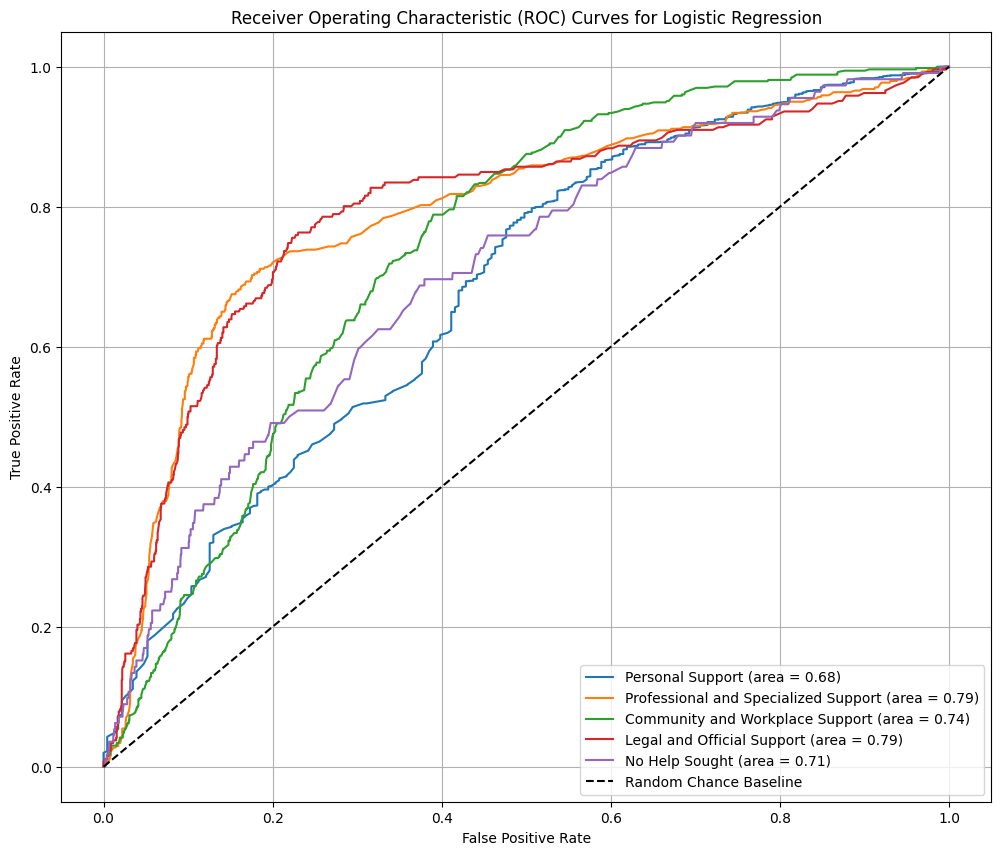

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
def plot_multiclass_roc_auc(y_true, y_scores, targets, figsize=(12, 10)):
    plt.figure(figsize=figsize)

    #Calculate ROC-AUC
    for i, target in enumerate(targets):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{target} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves for Logistic Regression')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


y_scores = np.column_stack([model.predict_proba(X_test_scaled)[:, 1] for model in classifiers])

y_true = y_test.to_numpy()
#Plot ROC-AUC curves
plot_multiclass_roc_auc(y_true, y_scores, targets)